# PART 2 - Reliability, Evaluation, ROC, Briers etc.

In [16]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats
import random
from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Load OASIS dataset, clean and preprocess. 
df = pd.read_csv("oasis_longitudinal.csv")
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])


### Model Training and Testing: script in the below chunk is copied from Part-1 Notebook and can mainly be ignored.
Only edits from Part-1 are to include saving true values and probabilities within the repeated_evaluation function. 

In [18]:
# === Model Training and Testing ===

evaluation_outputs = {}

def repeated_evaluation(model, X, y, label, sex=None, sex_filter=None, groups=None, n_splits=5, n_repeats=5):
    fold_metrics = []
    y_true_folds = []
    y_proba_folds = []
    for repeat in range(n_repeats):
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED + repeat)
        for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled) [:, 1]
            y_true_folds.append(y_test.values)
            y_proba_folds.append(y_proba)
            if sex is not None and sex_filter is not None:
                test_sex = sex.iloc[test_idx]
                mask = test_sex == sex_filter
                if not mask.any():
                    continue
                y_test = y_test[mask]
                y_pred = y_pred[mask]
                y_proba = y_proba[mask]
            y_true_folds.append(y_test.values)
            y_proba_folds.append(y_proba)
        
        fold_metrics.append({
            'repeat': repeat,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'y_true': y_test.values,
            'y_proba': y_proba
            })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics = metrics_df[['accuracy', 'balanced_accuracy','f1', 'precision', 'recall', 'roc_auc']]
    metrics_df.attrs['y_true_all'] = np.concatenate(y_true_folds).tolist()
    metrics_df.attrs['y_proba_all'] = np.concatenate(y_proba_folds).tolist()
    evaluation_outputs[label] = metrics_df
    
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['balanced_accuracy'], stds['balanced_accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

# === General LR models ===
LR_RF_results = []
results_folds = {}

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-F"] = folds
# === General RF models ===

summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-F"] = folds

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']
X_f, y_f = df_female[my_features], df_female['Group']


summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_m, y_m, "Male-LR-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_f, y_f, "Female-LR-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-LR-F"] = folds


summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_m, y_m, "Male-RF-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-RF-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_f, y_f, "Female-RF-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-RF-F"] = folds

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'BalancedAccuracy_mean', 'BalancedAccuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(LR_RF_results, columns=columns)
n_splits, n_repeats = 5, 5
metrics = ['Accuracy', 'BalancedAccuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se

xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_m, y_m, 'Male-XGB-M', groups=groups_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_f, y_f, 'Female-XGB-F', groups=groups_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds

xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)

svm_vote_results = []
svm_vote_fold_results = {}

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_m, y_m, 'Male-SVM-M', groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_f, y_f, 'Female-SVM-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

# === VC general models ===

summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_m, y_m, 'Male-VC-M',  groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_f, y_f, 'Female-VC-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VC-F'] = folds

# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se

all_results_table = pd.concat([results_table, xgb_results_table, svm_vote_results_table], ignore_index=True)


## Evaluation of Models: ROC Curve

In [26]:
# Evaluation of models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import Image, display

def plot_roc_auc(model_probs: dict[str, np.array], y_true: np.ndarray, save_path: str | None = None) -> dict[str, float]:
    aucs: dict[str, float] = {}
    plt.figure()
    for name, prob in model_probs.items():
        fpr, tpr, _ = roc_curve(y_true, prob)
        model_auc = auc(fpr, tpr)
        aucs[name] = model_auc
        plt.plot(fpr, tpr, label=f'{name} (AUC={model_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()
    return aucs

def decision_curve(y_true: np.ndarray, prob: np.ndarray, thresholds: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    y_true = np.asarray(y_true)
    prob = np.asarray(prob)
    n = len(y_true)
    net_benefits = []
    for thr in thresholds:
        pred_pos = prob >= thr
        tp = np.sum((pred_pos == 1) & (y_true == 1))
        fp = np.sum((pred_pos == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (thr / (1 - thr))
        net_benefits.append(net_benefit)
    return np.asarray(thresholds), np.asarray(net_benefits)

def plot_decision_curves(model_probs: dict[str, np.ndarray], y_true: np.ndarray, thresholds: np.ndarray | None = None, save_path: str | None = None) -> None:
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    plt.figure()
    for name, prob in model_probs.items():
        thr, nb = decision_curve(y_true, prob, thresholds)
        plt.plot(thr, nb, label=name)
    plt.xlabel('Threshold Probability')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()

def reliability_diagram(y_true: np.ndarray, prob: np.ndarray, n_bins: int = 10) -> tuple[np.ndarray, np.ndarray, float]:
    frac_pos, mean_pred = calibration_curve(y_true, prob, n_bins=n_bins)
    brier = brier_score_loss(y_true, prob)
    return mean_pred, frac_pos, brier

def plot_reliability_curves(model_probs: dict[str, np.ndarray], y_true: np.ndarray, n_bins: int = 10, save_path: str | None = None) -> dict[str, float]:
    briers: dict[str, float] = {}
    plt.figure()
    for name, prob in model_probs.items():
        mean_pred, frac_pos, brier = reliability_diagram(y_true, prob, n_bins=n_bins)
        briers[name] = brier
        plt.plot(mean_pred, frac_pos, marker='o', label=f'{name} (Brier={brier:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    return briers


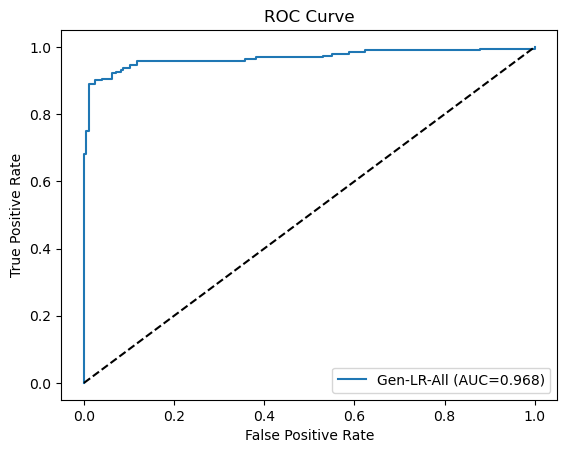

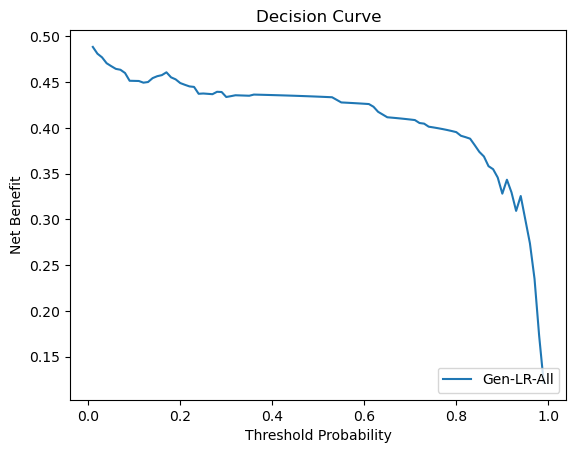

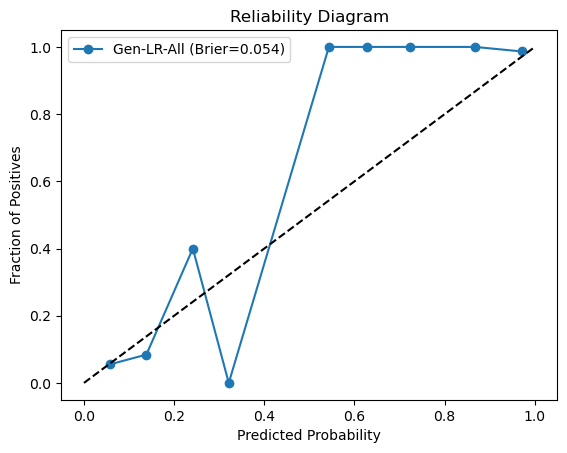

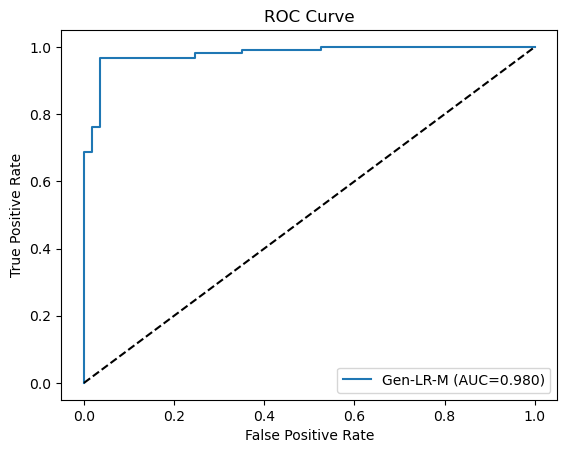

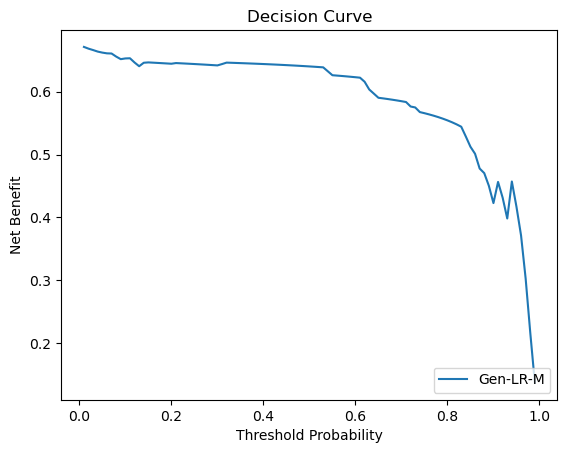

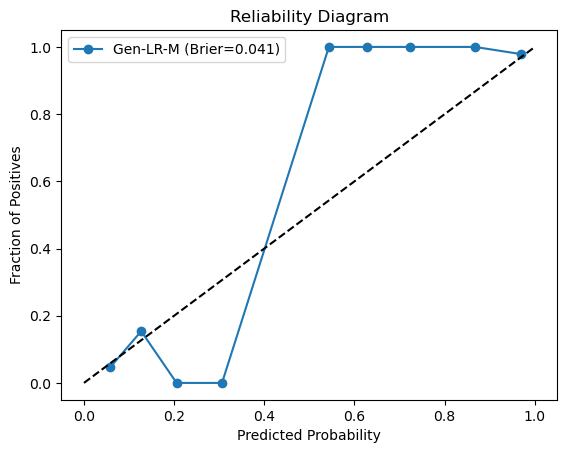

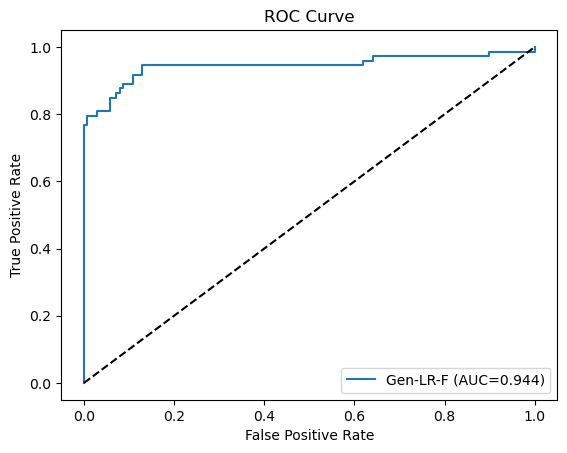

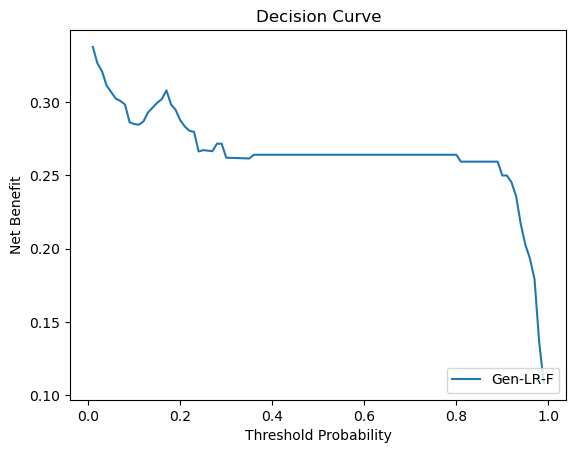

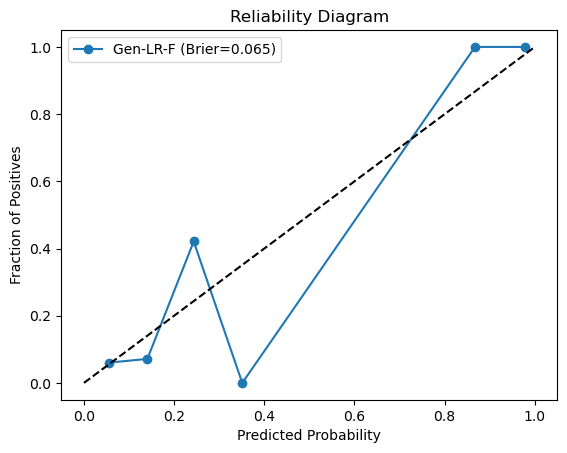

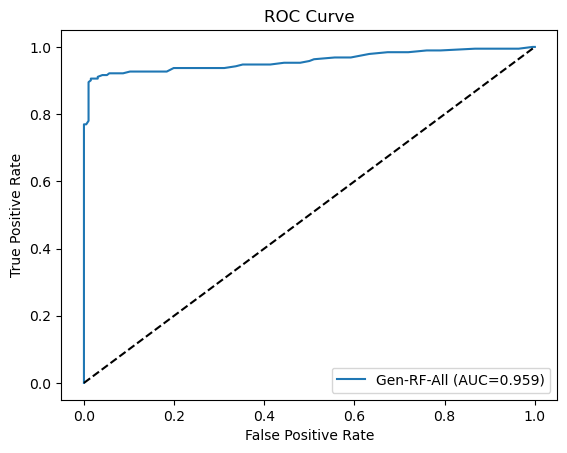

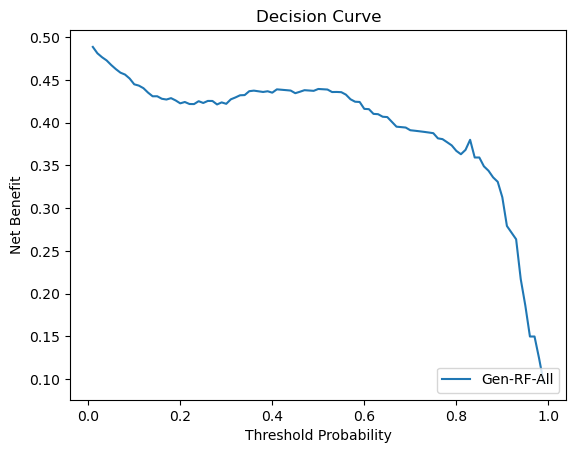

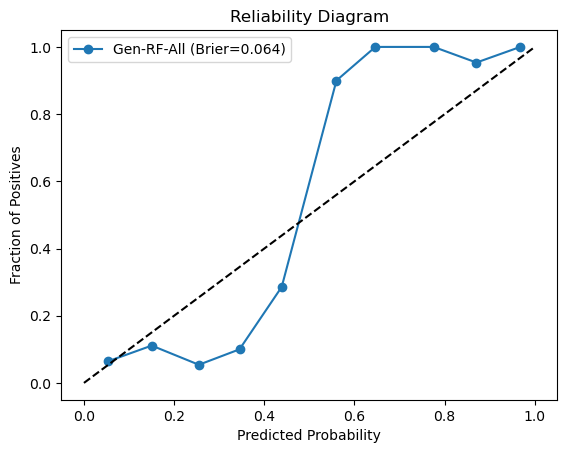

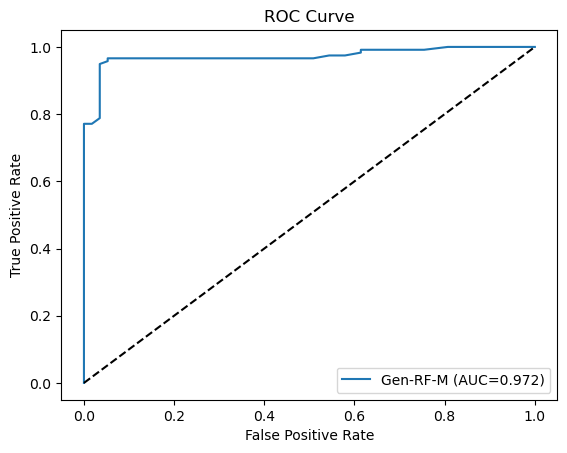

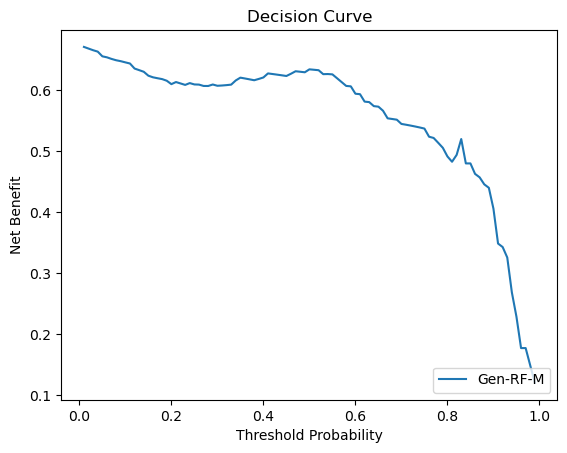

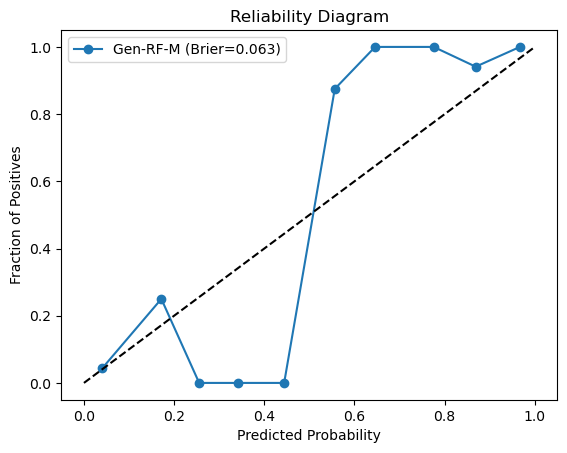

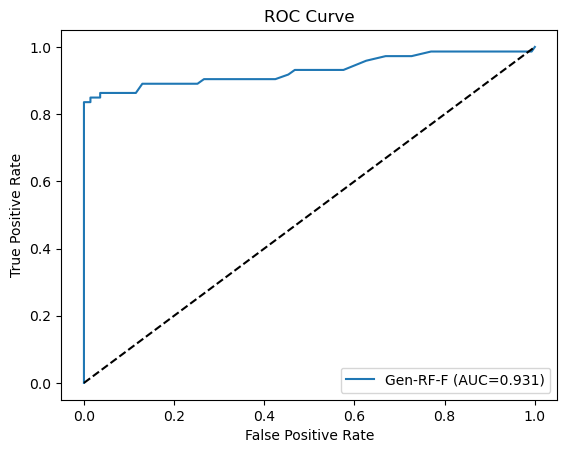

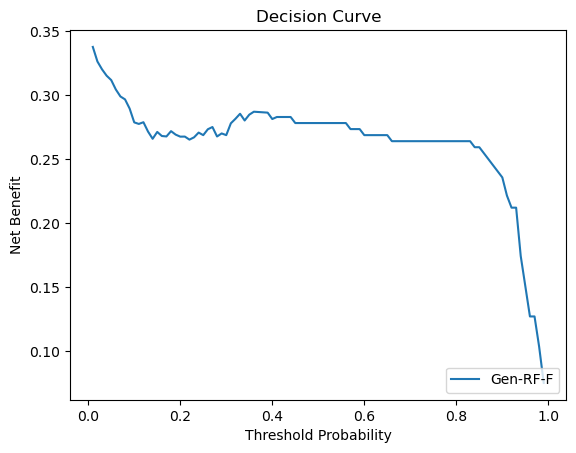

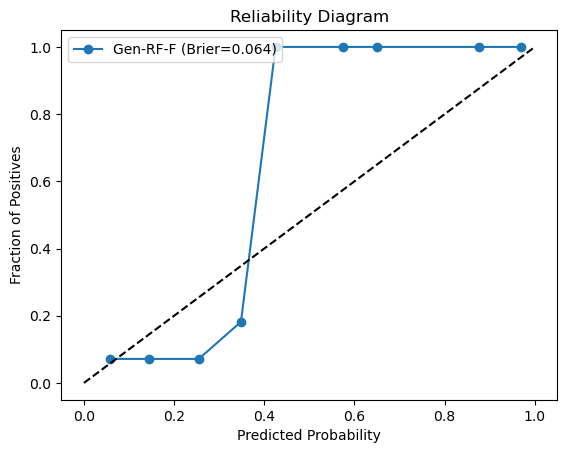

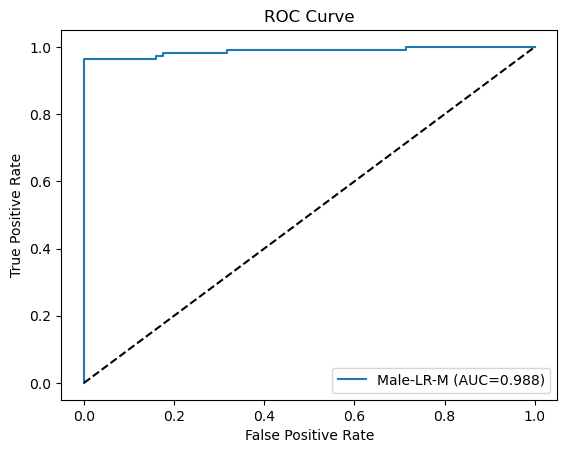

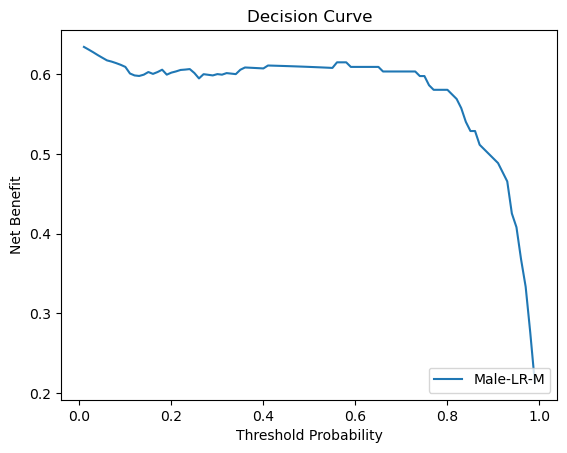

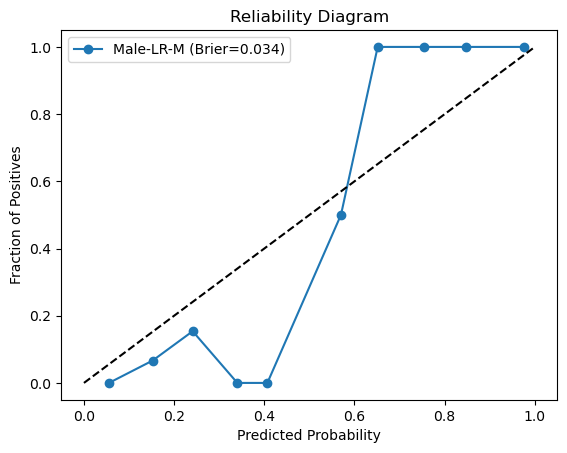

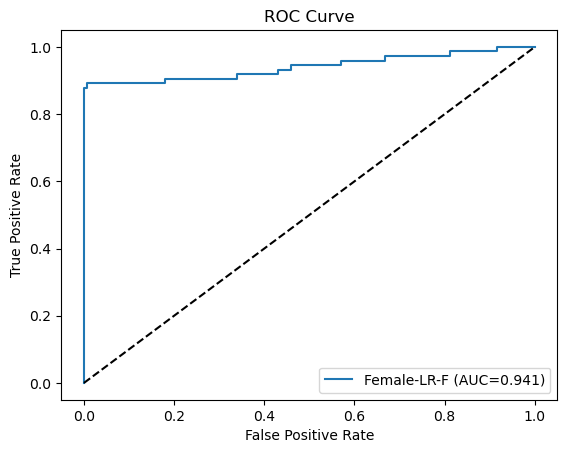

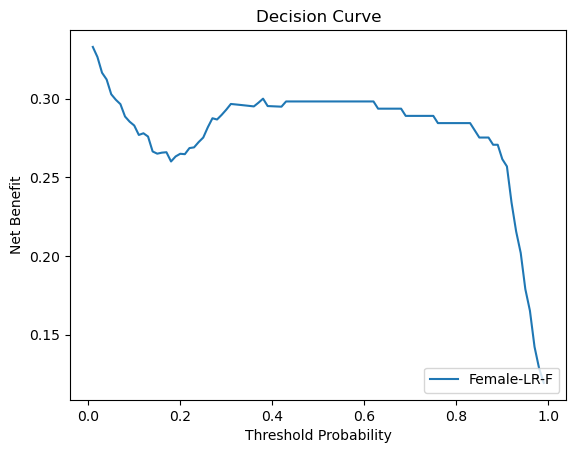

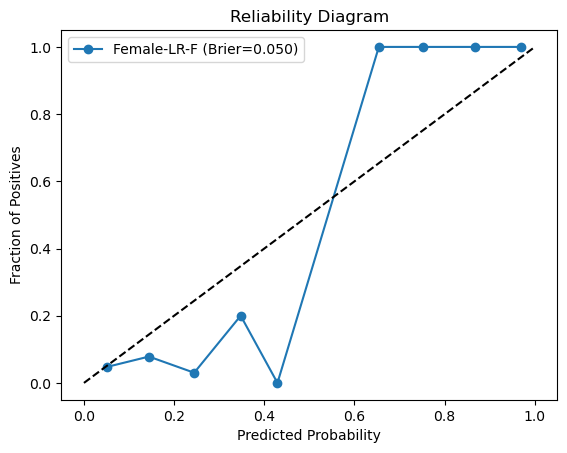

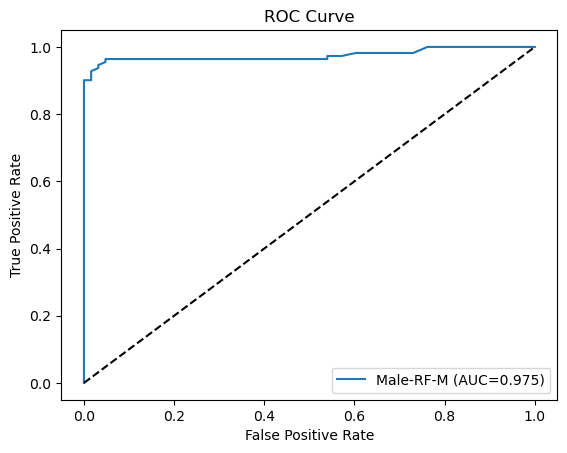

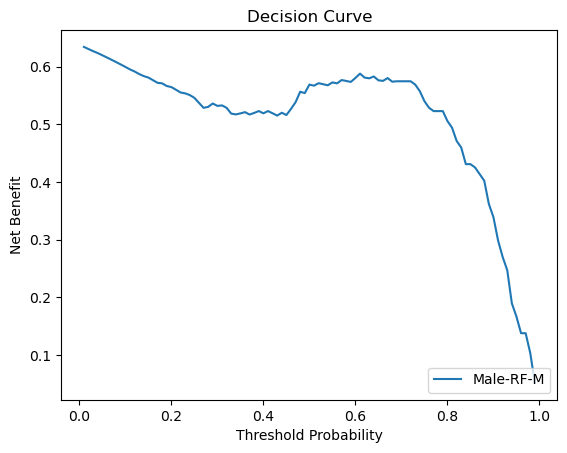

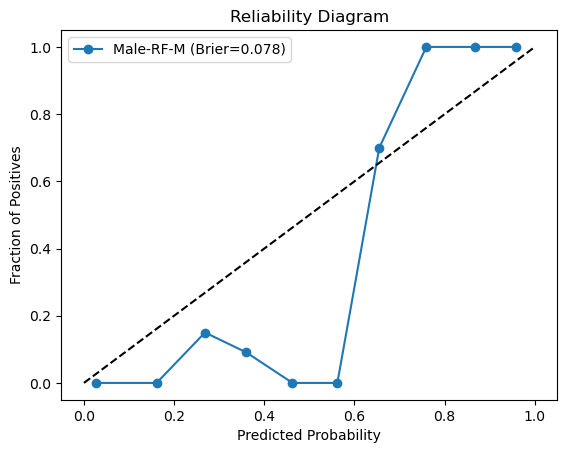

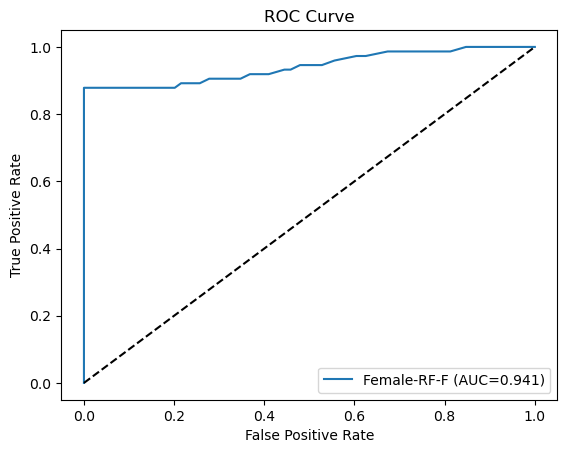

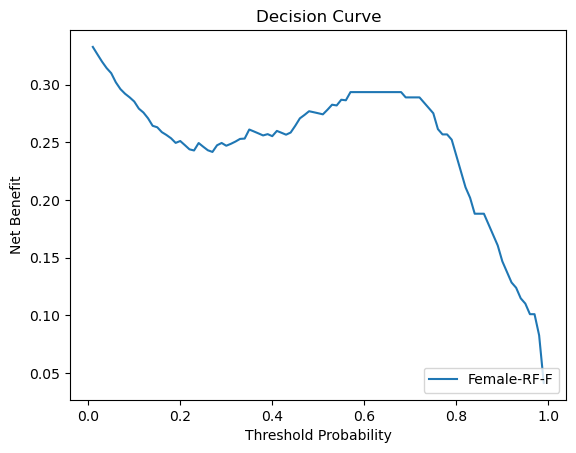

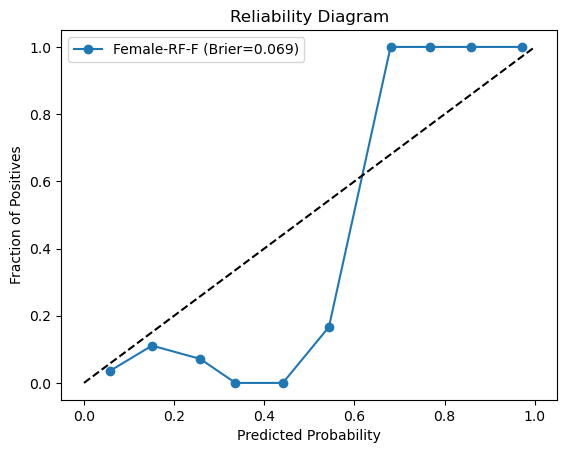

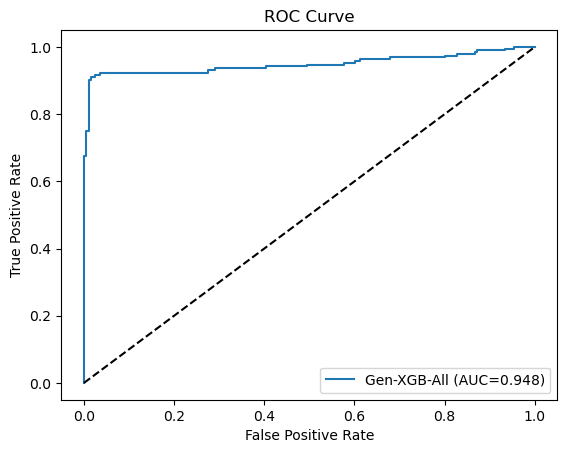

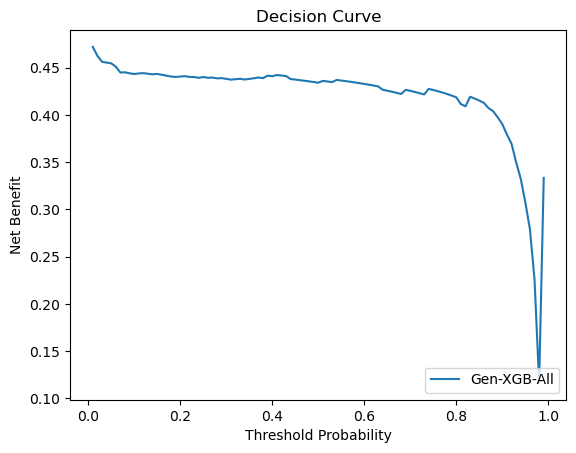

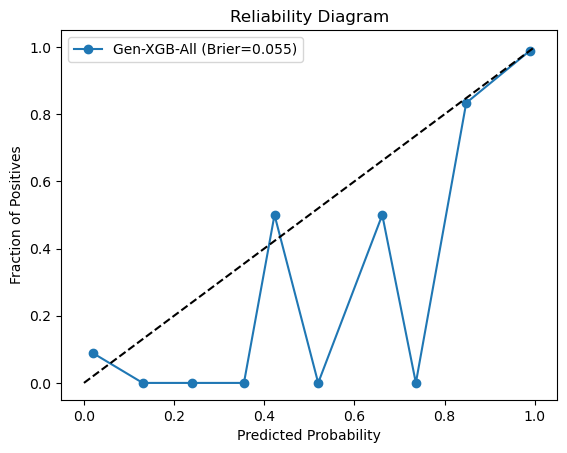

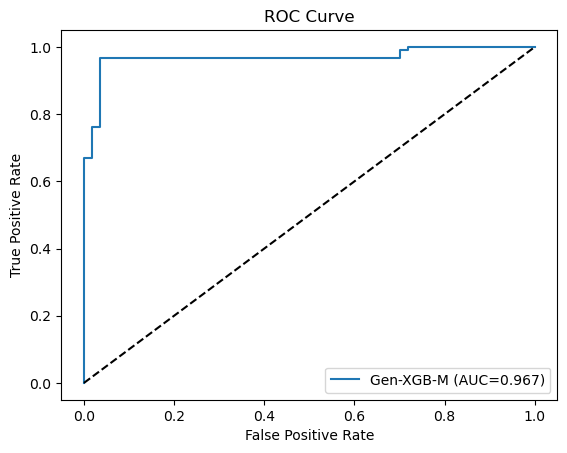

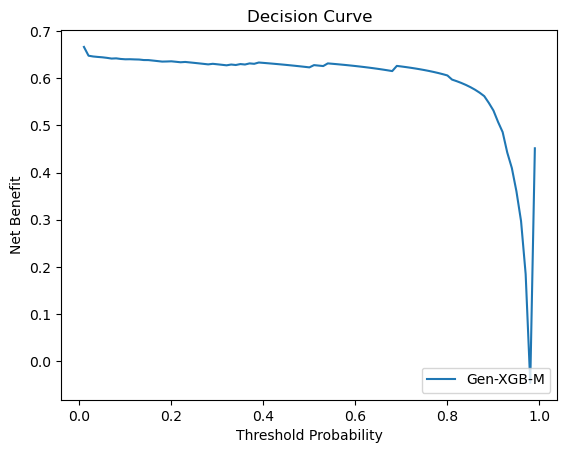

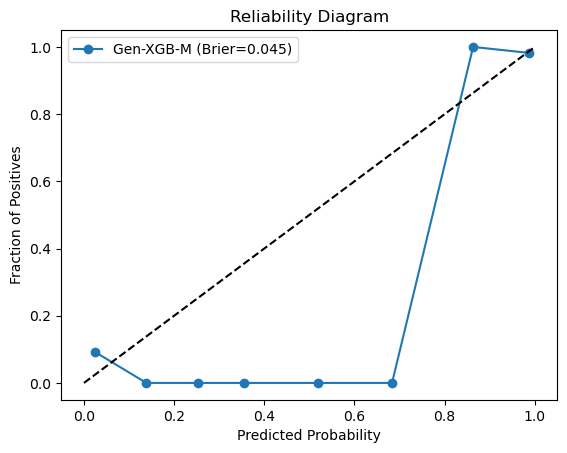

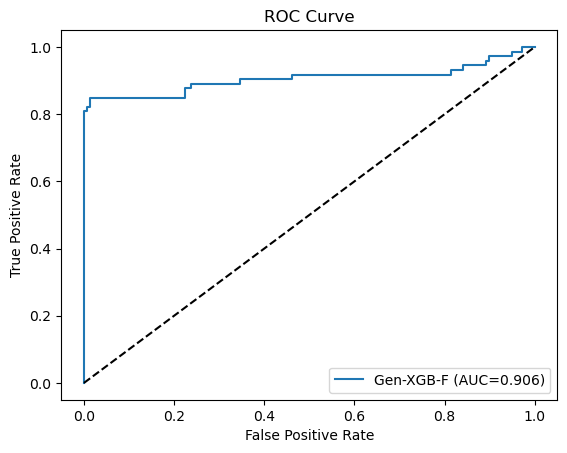

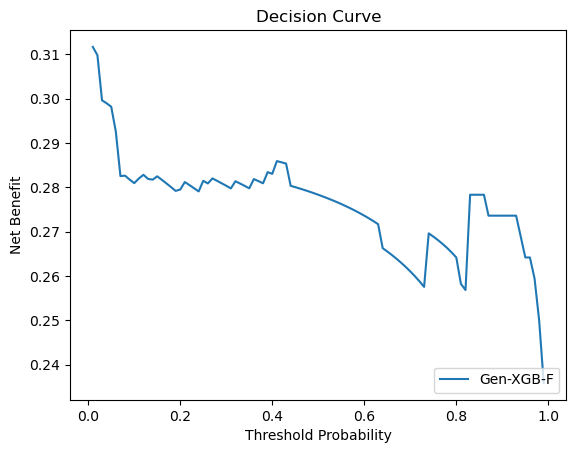

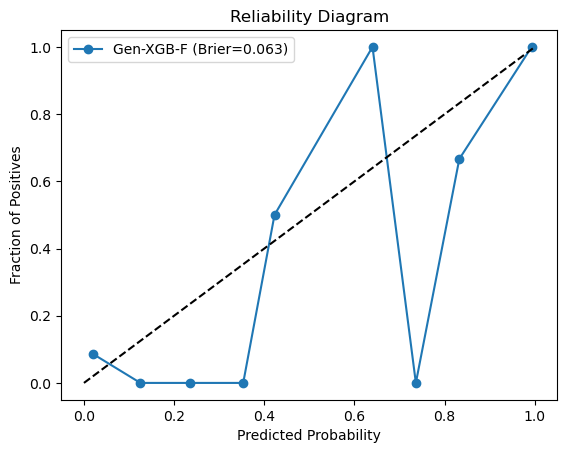

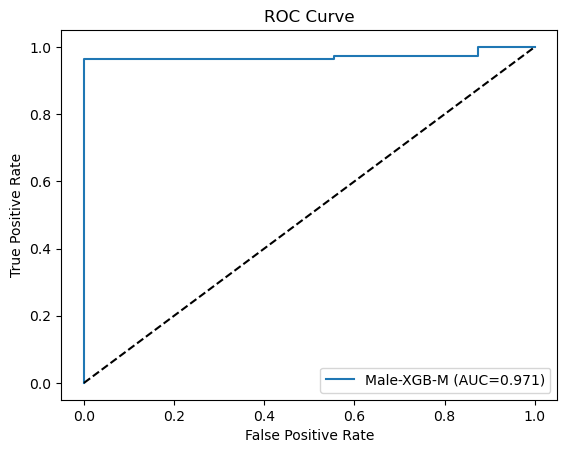

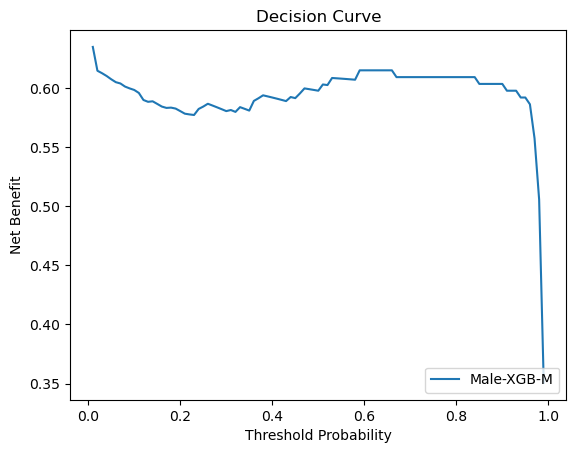

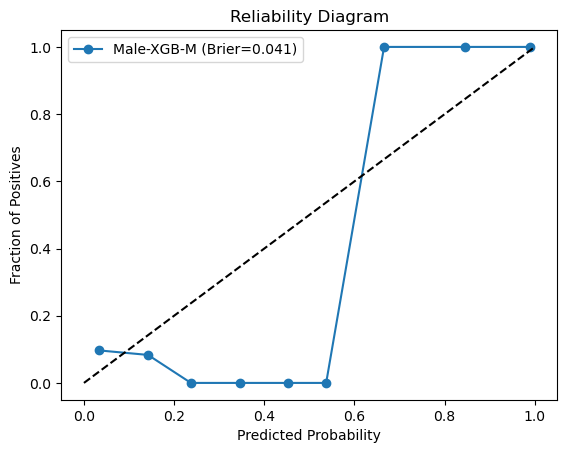

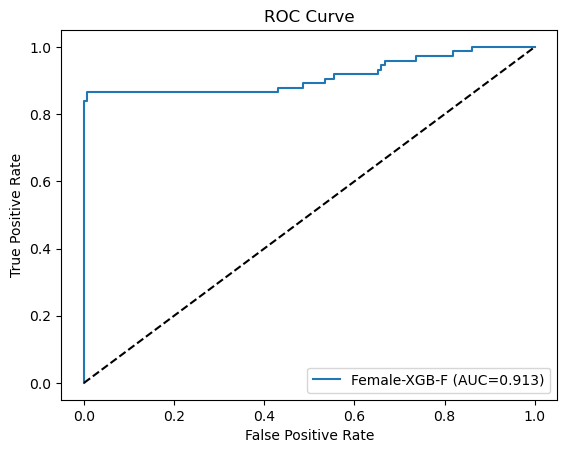

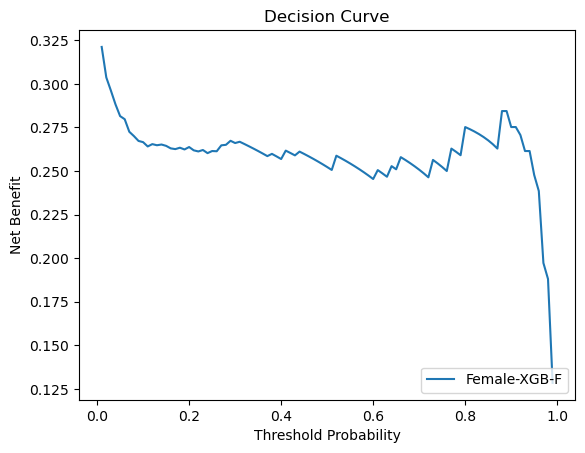

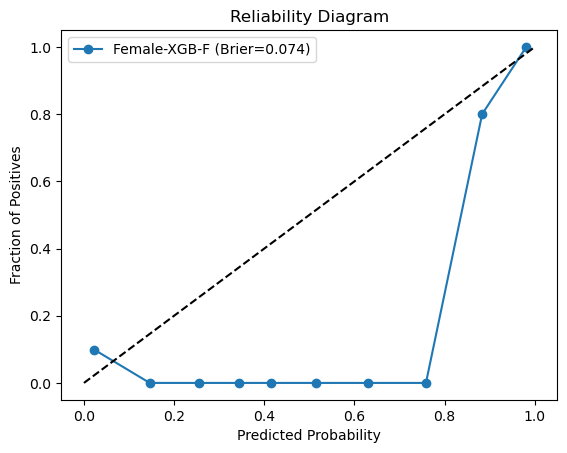

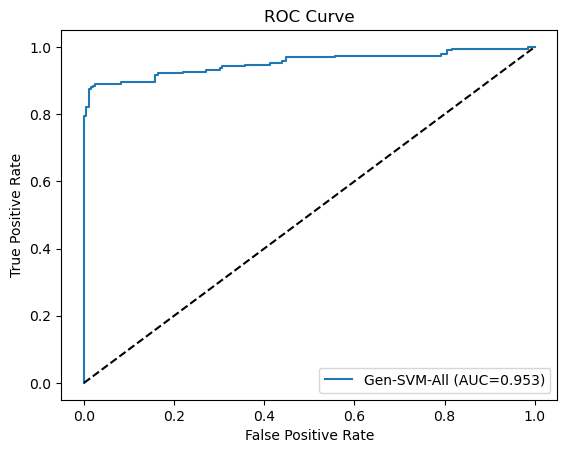

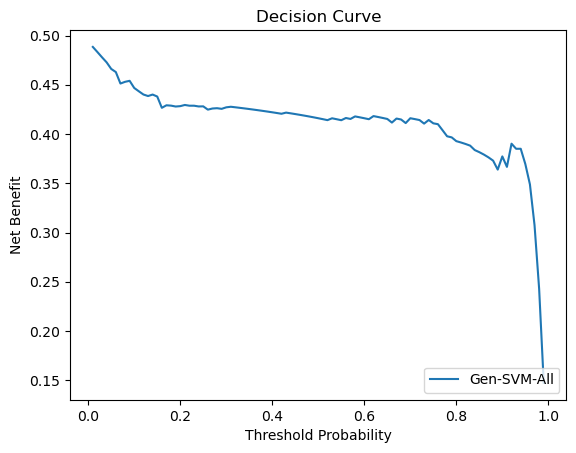

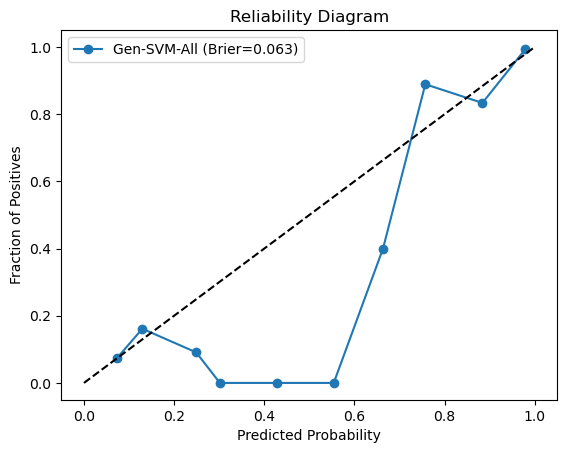

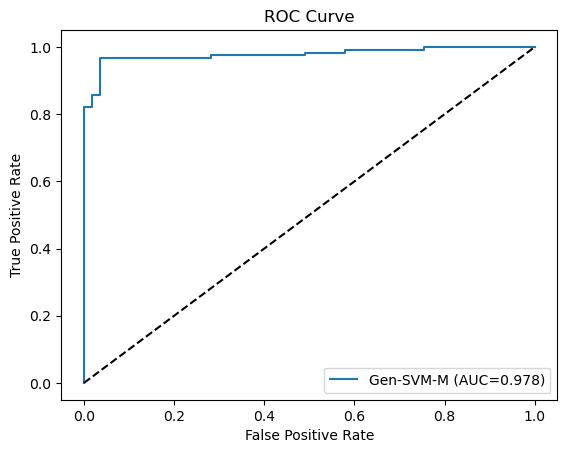

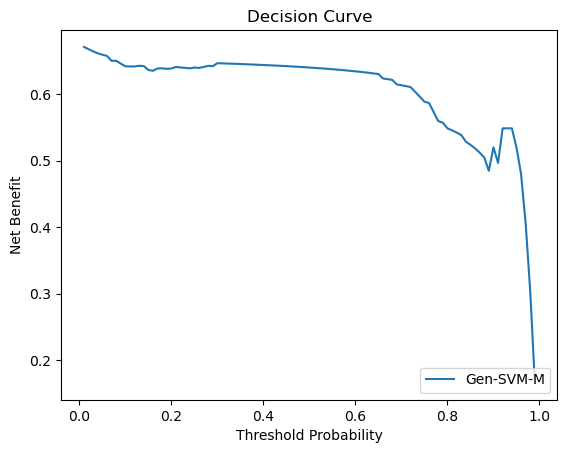

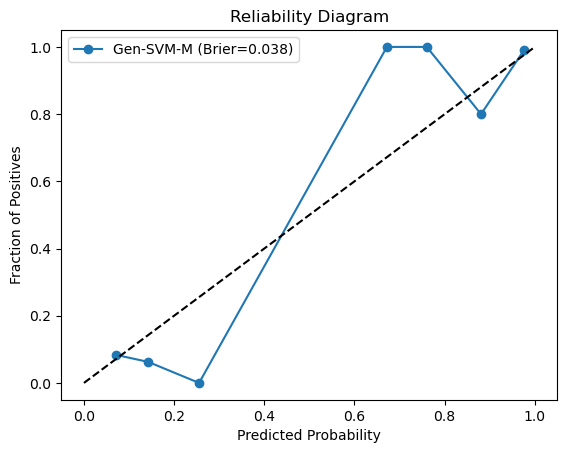

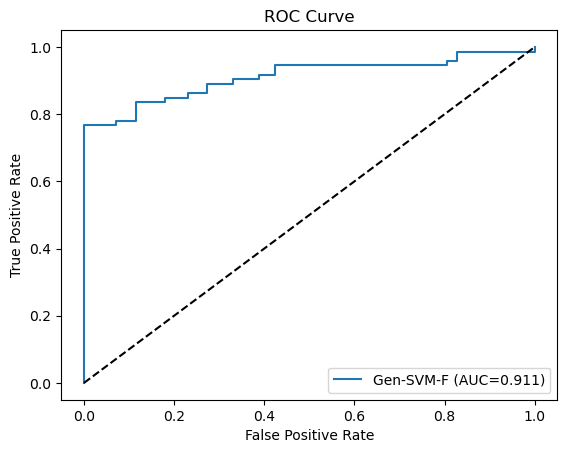

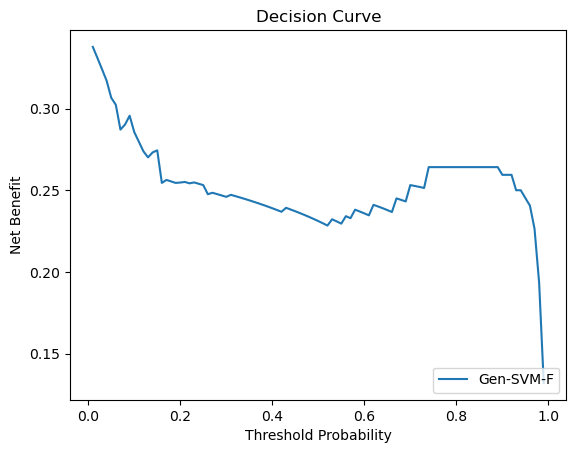

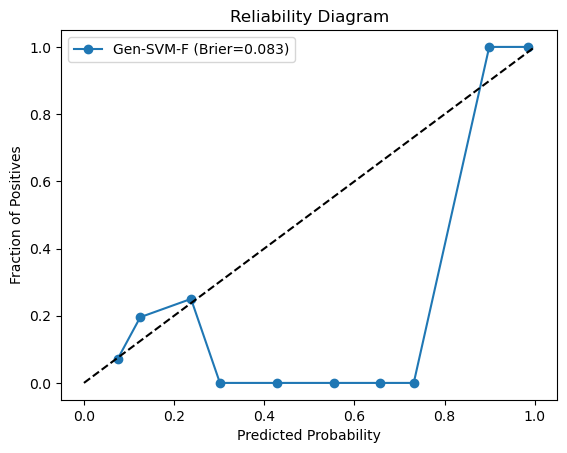

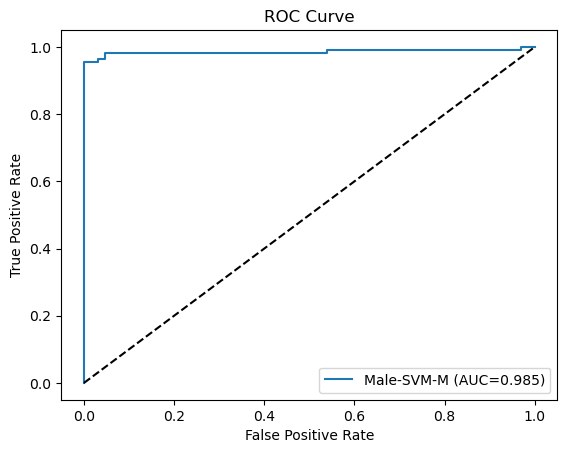

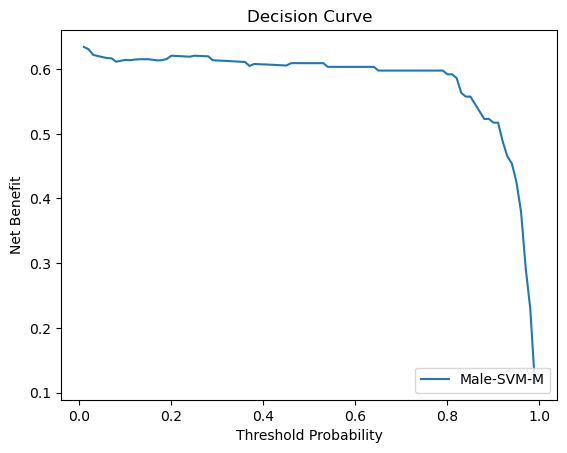

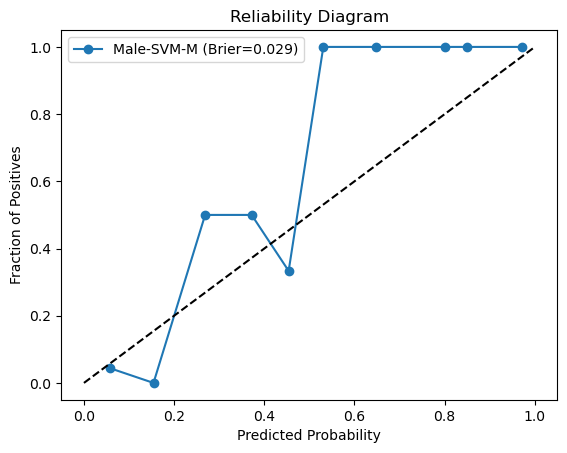

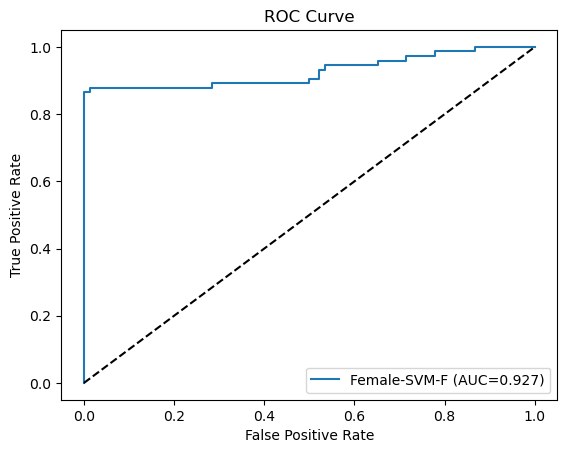

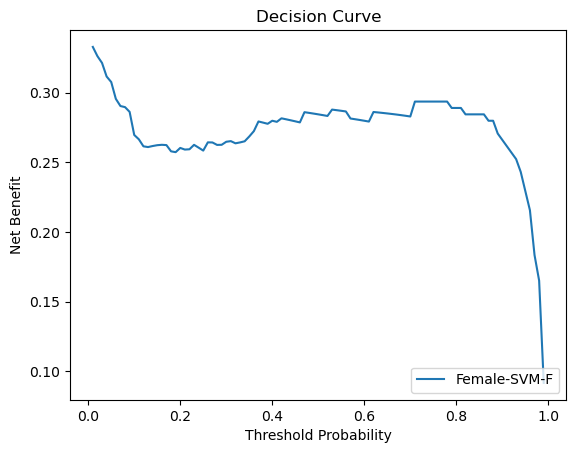

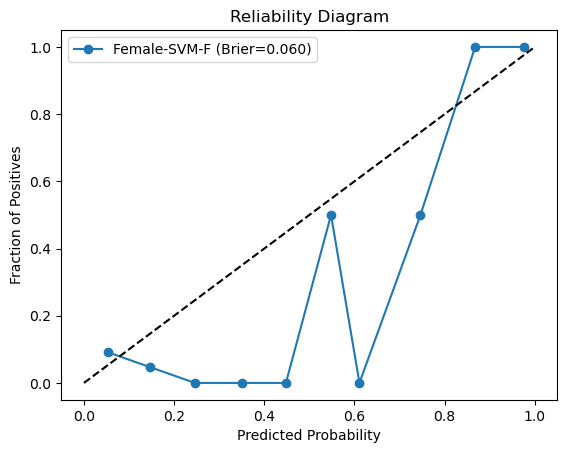

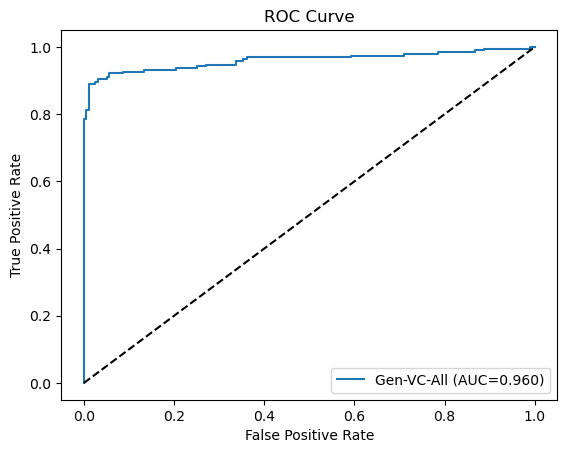

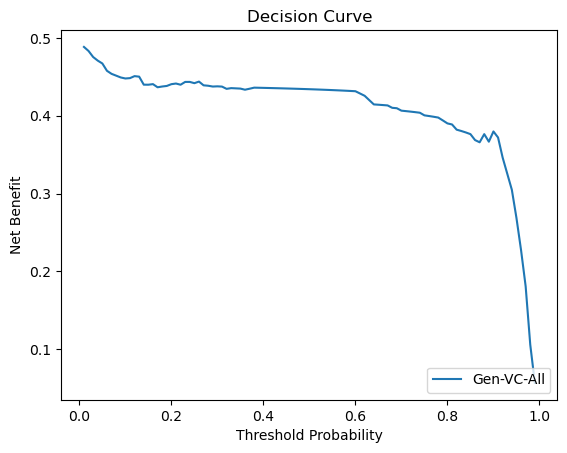

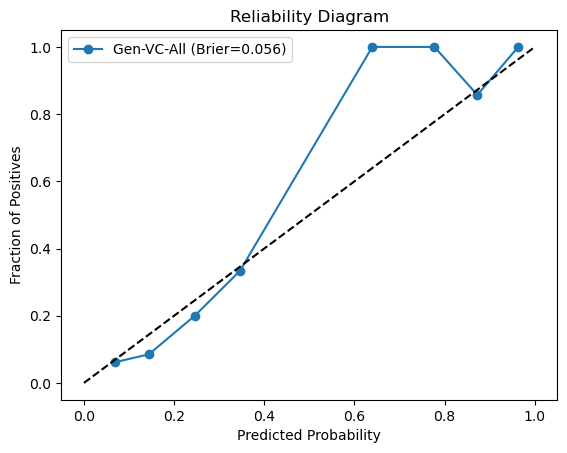

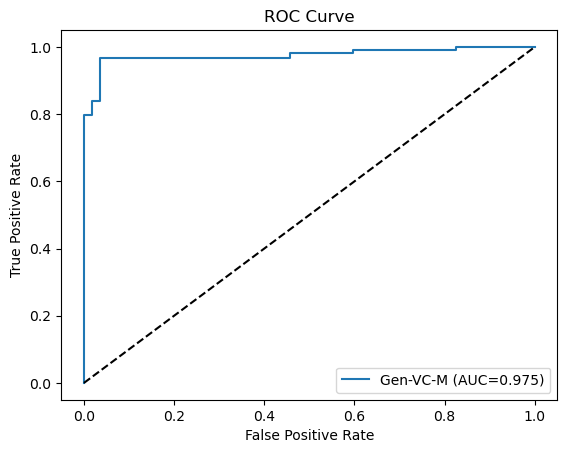

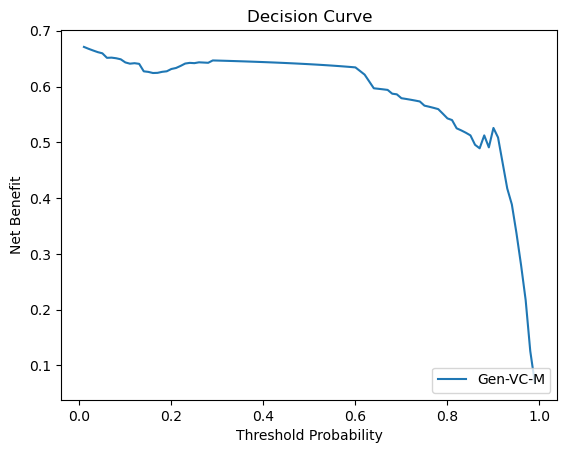

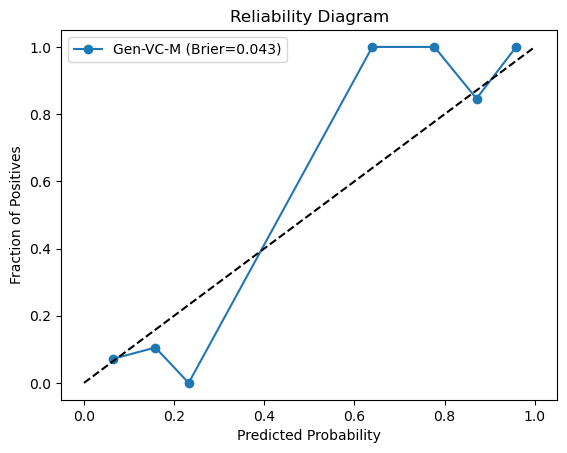

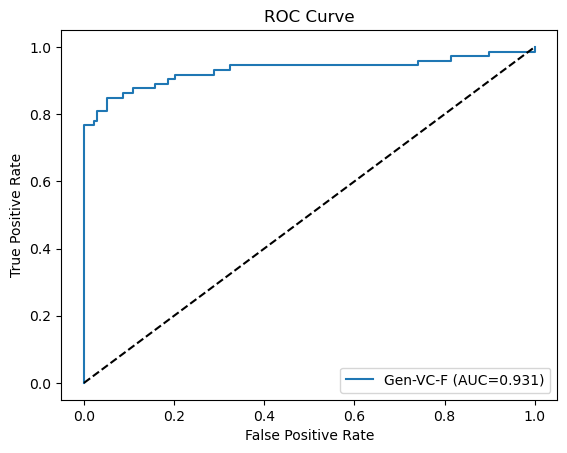

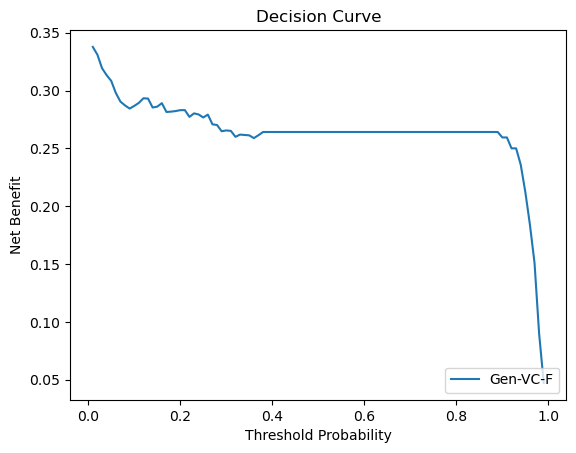

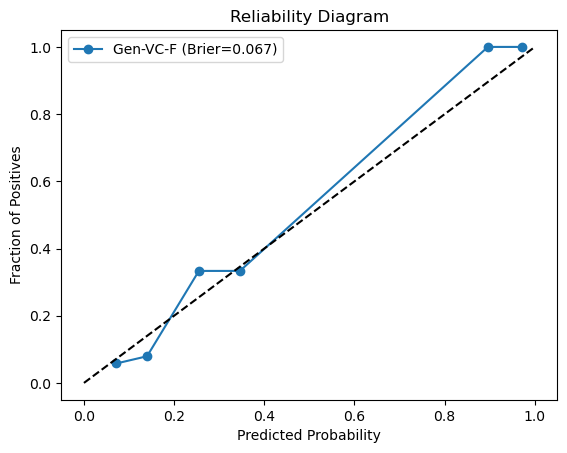

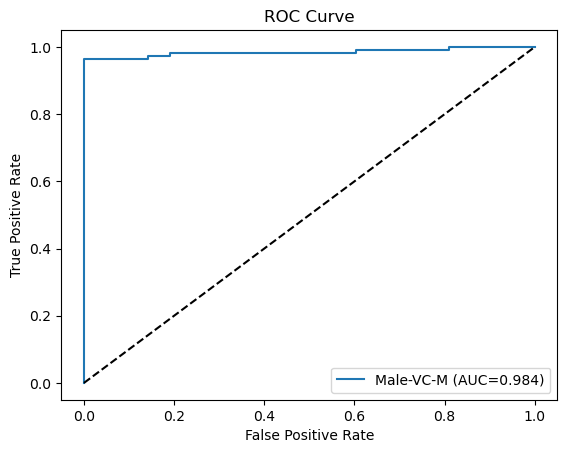

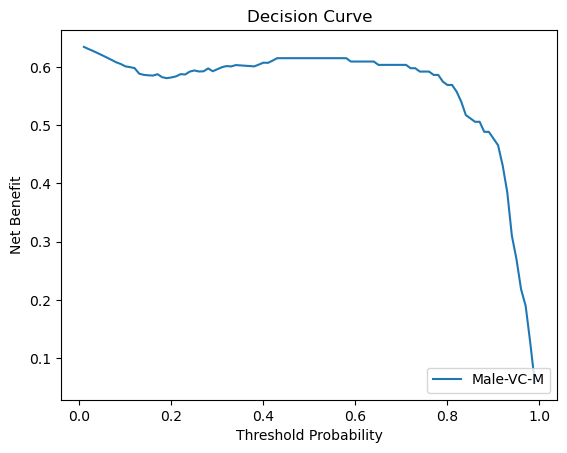

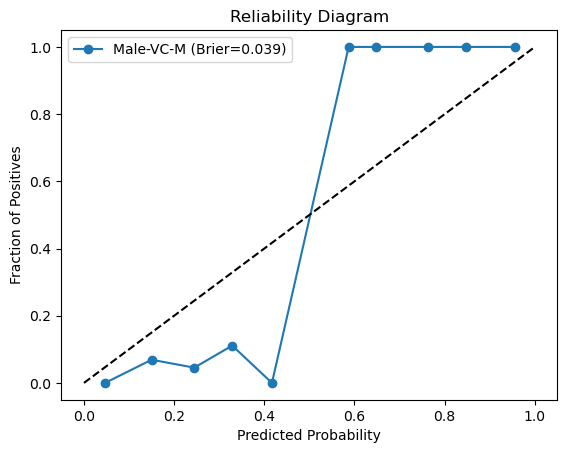

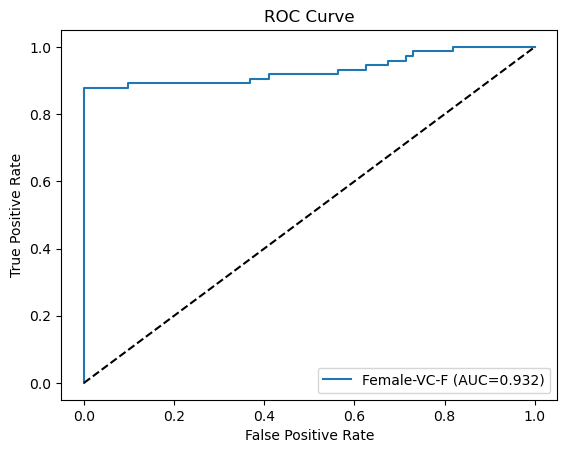

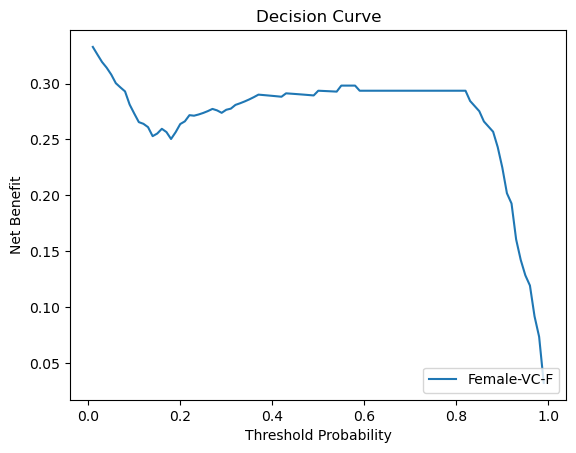

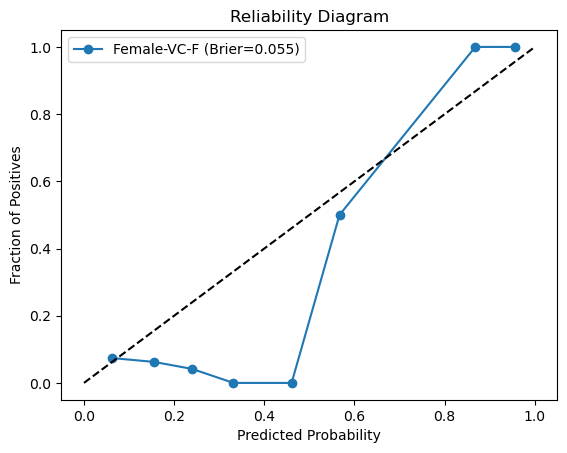

In [28]:

# === GENERATE MODEL PLOTS ===

for label, df in evaluation_outputs.items():
    y_true = np.concatenate(df['y_true'].to_numpy())
    y_proba = np.concatenate(df['y_proba'].to_numpy())
    model_probs = {label: y_proba}
    plot_roc_auc(model_probs, y_true)
    plot_decision_curves(model_probs, y_true)
    plot_reliability_curves(model_probs, y_true)

In [30]:
from sklearn.metrics import brier_score_loss
import numpy as np

def brier_baseline(y_true):
    pi = float(np.mean(y_true))
    return pi * (1 - pi)

def brier_skill_score(y_true, prob):
    bs = brier_score_loss(y_true, prob)
    bs_ref = brier_baseline(y_true)
    return 1 - bs / bs_ref, bs, bs_ref


for label, df in evaluation_outputs.items():
    y_true = np.concatenate(df['y_true'].to_numpy())
    y_proba = np.concatenate(df['y_proba'].to_numpy())
    bss, bs, bs_ref = brier_skill_score(y_true, y_proba)
    print(f"{label}: BS={bs:.4f}, baseline={bs_ref:.4f}, BSS={bss:.3f}")


Gen-LR-All: BS=0.0543, baseline=0.2500, BSS=0.783
Gen-LR-M: BS=0.0409, baseline=0.2196, BSS=0.814
Gen-LR-F: BS=0.0655, baseline=0.2258, BSS=0.710
Gen-RF-All: BS=0.0637, baseline=0.2500, BSS=0.745
Gen-RF-M: BS=0.0627, baseline=0.2196, BSS=0.714
Gen-RF-F: BS=0.0644, baseline=0.2258, BSS=0.715
Male-LR-M: BS=0.0339, baseline=0.2310, BSS=0.853
Female-LR-F: BS=0.0503, baseline=0.2242, BSS=0.775
Male-RF-M: BS=0.0785, baseline=0.2310, BSS=0.660
Female-RF-F: BS=0.0693, baseline=0.2242, BSS=0.691
Gen-XGB-All: BS=0.0547, baseline=0.2500, BSS=0.781
Gen-XGB-M: BS=0.0446, baseline=0.2196, BSS=0.797
Gen-XGB-F: BS=0.0630, baseline=0.2258, BSS=0.721
Male-XGB-M: BS=0.0413, baseline=0.2310, BSS=0.821
Female-XGB-F: BS=0.0741, baseline=0.2242, BSS=0.670
Gen-SVM-All: BS=0.0630, baseline=0.2500, BSS=0.748
Gen-SVM-M: BS=0.0383, baseline=0.2196, BSS=0.826
Gen-SVM-F: BS=0.0834, baseline=0.2258, BSS=0.631
Male-SVM-M: BS=0.0288, baseline=0.2310, BSS=0.875
Female-SVM-F: BS=0.0603, baseline=0.2242, BSS=0.731
Gen-VC

In [38]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from numpy.random import default_rng

def auc_with_ci(y_true: np.ndarray, prob: np.ndarray, n_boot: int = 2000, seed: int = 0):
    
    y_true = np.asarray(y_true).astype(int)
    prob = np.asarray(prob, dtype=float)
# sanity check!!!
    if len(np.unique(y_true)) < 2:
        return dict(
            roc_auc=np.nan, roc_auc_ci=(np.nan, np.nan),
            pr_auc=np.nan,  pr_auc_ci=(np.nan, np.nan),
            note="Only one class present; AUC undefined."
        )

    roc = roc_auc_score(y_true, prob)
    pr  = average_precision_score(y_true, prob)

    rng = default_rng(seed)
    n = len(y_true)
    roc_samp, pr_samp = [], []

    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    for _ in range(n_boot):
        b_pos = rng.choice(pos_idx, size=len(pos_idx), replace=True)
        b_neg = rng.choice(neg_idx, size=len(neg_idx), replace=True)
        b_idx = np.concatenate([b_pos, b_neg])
        yt_b = y_true[b_idx]
        pr_b = prob[b_idx]

        if len(np.unique(yt_b)) < 2:
            continue
        roc_samp.append(roc_auc_score(yt_b, pr_b))
        pr_samp.append(average_precision_score(yt_b, pr_b))

    roc_ci = (np.percentile(roc_samp, 2.5), np.percentile(roc_samp, 97.5)) if roc_samp else (np.nan, np.nan)
    pr_ci  = (np.percentile(pr_samp, 2.5),  np.percentile(pr_samp, 97.5))  if pr_samp else (np.nan, np.nan)

    return dict(
        roc_auc=float(roc), roc_auc_ci=tuple(map(float, roc_ci)),
        pr_auc=float(pr),   pr_auc_ci=tuple(map(float, pr_ci))
    )


for label, df in evaluation_outputs.items():
    y_true = np.concatenate(df['y_true'].to_numpy()).astype(int)
    y_proba = np.concatenate(df['y_proba'].to_numpy()).astype(float)

    res = auc_with_ci(y_true, y_proba, n_boot=2000, seed=42)
    print(
        f"{label}: ROC AUC={res['roc_auc']:.3f} "
        f"[{res['roc_auc_ci'][0]:.3f}, {res['roc_auc_ci'][1]:.3f}]  |  "
        f"PR AUC={res['pr_auc']:.3f} "
        f"[{res['pr_auc_ci'][0]:.3f}, {res['pr_auc_ci'][1]:.3f}]"
    )


Gen-LR-All: ROC AUC=0.968 [0.946, 0.985]  |  PR AUC=0.977 [0.963, 0.989]
Gen-LR-M: ROC AUC=0.980 [0.959, 0.995]  |  PR AUC=0.990 [0.980, 0.998]
Gen-LR-F: ROC AUC=0.944 [0.897, 0.980]  |  PR AUC=0.944 [0.906, 0.975]
Gen-RF-All: ROC AUC=0.959 [0.936, 0.979]  |  PR AUC=0.971 [0.956, 0.985]
Gen-RF-M: ROC AUC=0.972 [0.946, 0.992]  |  PR AUC=0.988 [0.977, 0.996]
Gen-RF-F: ROC AUC=0.931 [0.882, 0.972]  |  PR AUC=0.934 [0.890, 0.971]
Male-LR-M: ROC AUC=0.988 [0.971, 0.999]  |  PR AUC=0.994 [0.987, 0.999]
Female-LR-F: ROC AUC=0.941 [0.893, 0.980]  |  PR AUC=0.945 [0.905, 0.980]
Male-RF-M: ROC AUC=0.975 [0.950, 0.994]  |  PR AUC=0.989 [0.978, 0.997]
Female-RF-F: ROC AUC=0.941 [0.898, 0.977]  |  PR AUC=0.941 [0.899, 0.976]
Gen-XGB-All: ROC AUC=0.948 [0.920, 0.972]  |  PR AUC=0.967 [0.949, 0.982]
Gen-XGB-M: ROC AUC=0.967 [0.938, 0.990]  |  PR AUC=0.986 [0.974, 0.996]
Gen-XGB-F: ROC AUC=0.906 [0.843, 0.959]  |  PR AUC=0.920 [0.871, 0.962]
Male-XGB-M: ROC AUC=0.971 [0.942, 0.995]  |  PR AUC=0.989 [0

In [42]:
import numpy as np
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    roc_auc_score, average_precision_score, brier_score_loss
)

def metrics_at(y_true, y_proba, th):
    yhat = (y_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    sens = tp/(tp+fn) if (tp+fn) else np.nan   # recall
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    prec = tp/(tp+fp) if (tp+fp) else np.nan   # precision
    npv  = tn/(tn+fn) if (tn+fn) else np.nan
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                sensitivity=sens, specificity=spec,
                precision=prec, npv=npv)

def summarize_model(y_true, y_proba):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba).astype(float)
    pi = y_true.mean()
    bs = brier_score_loss(y_true, y_proba)
    bs_ref = pi*(1-pi)
    bss = 1 - bs/bs_ref if bs_ref > 0 else np.nan
    auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true))==2 else np.nan
    pr  = average_precision_score(y_true, y_proba) if len(np.unique(y_true))==2 else np.nan

    fpr, tpr, thr = roc_curve(y_true, y_proba)
    youden_idx = np.argmax(tpr - fpr)
    thr_j = thr[youden_idx]

    prec, rec, thr_pr = precision_recall_curve(y_true, y_proba)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    thr_f1 = thr_pr[np.nanargmax(f1[:-1])]  # last PR point has no threshold

    out = {
        "prevalence": pi, "BS": bs, "BS_baseline": bs_ref, "BSS": bss,
        "ROC_AUC": auc, "PR_AUC": pr,
        "thr@0.50": 0.50, **{f"0.50_{k}": v for k,v in metrics_at(y_true, y_proba, 0.50).items()},
        "thr@J": thr_j,   **{f"J_{k}":    v for k,v in metrics_at(y_true, y_proba, thr_j).items()},
        "thr@F1": thr_f1, **{f"F1_{k}":   v for k,v in metrics_at(y_true, y_proba, thr_f1).items()},
    }
    return out

all_results = {}
for label, df in evaluation_outputs.items():
    y_true = np.concatenate(df["y_true"].to_numpy())
    y_proba = np.concatenate(df["y_proba"].to_numpy())
    all_results[label] = summarize_model(y_true, y_proba)


for label, r in all_results.items():
    print(
        f"{label} | AUC={r['ROC_AUC']:.3f} | PR AUC={r['PR_AUC']:.3f} | "
        f"BS={r['BS']:.3f} (baseline {r['BS_baseline']:.3f}, BSS {r['BSS']:.3f}) | "
        f"thrJ={r['thr@J']:.3f}  J_sens={r['J_sensitivity']:.3f}  J_spec={r['J_specificity']:.3f}  "
        f"J_prec={r['J_precision']:.3f}"
    )


Gen-LR-All | AUC=0.968 | PR AUC=0.977 | BS=0.054 (baseline 0.250, BSS 0.783) | thrJ=0.538  J_sens=0.890  J_spec=0.990  J_prec=0.988
Gen-LR-M | AUC=0.980 | PR AUC=0.990 | BS=0.041 (baseline 0.220, BSS 0.814) | thrJ=0.538  J_sens=0.966  J_spec=0.965  J_prec=0.983
Gen-LR-F | AUC=0.944 | PR AUC=0.944 | BS=0.065 (baseline 0.226, BSS 0.710) | thrJ=0.172  J_sens=0.945  J_spec=0.871  J_prec=0.793
Gen-RF-All | AUC=0.959 | PR AUC=0.971 | BS=0.064 (baseline 0.250, BSS 0.745) | thrJ=0.520  J_sens=0.906  J_spec=0.985  J_prec=0.983
Gen-RF-M | AUC=0.972 | PR AUC=0.988 | BS=0.063 (baseline 0.220, BSS 0.714) | thrJ=0.550  J_sens=0.949  J_spec=0.965  J_prec=0.982
Gen-RF-F | AUC=0.931 | PR AUC=0.934 | BS=0.064 (baseline 0.226, BSS 0.715) | thrJ=0.410  J_sens=0.836  J_spec=1.000  J_prec=1.000
Male-LR-M | AUC=0.988 | PR AUC=0.994 | BS=0.034 (baseline 0.231, BSS 0.853) | thrJ=0.580  J_sens=0.964  J_spec=1.000  J_prec=1.000
Female-LR-F | AUC=0.941 | PR AUC=0.945 | BS=0.050 (baseline 0.224, BSS 0.775) | thrJ=

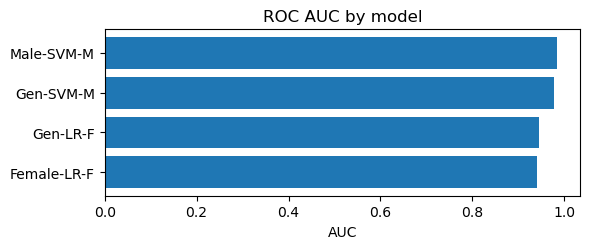

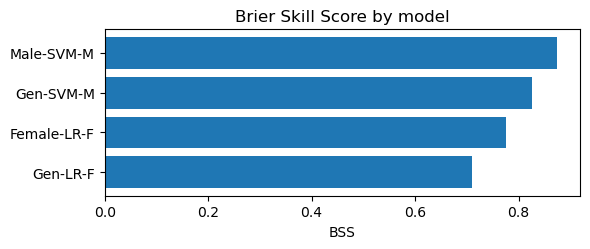

In [53]:
import numpy as np
import matplotlib.pyplot as plt


results = {
    "Male-SVM-M": {"ROC AUC": 0.985, "PR AUC": 0.994, "BSS": 0.875},
    "Gen-SVM-M":  {"ROC AUC": 0.978, "PR AUC": 0.991, "BSS": 0.826},
    "Female-LR-F":{"ROC AUC": 0.941, "PR AUC": 0.945, "BSS": 0.775},
    "Gen-LR-F":   {"ROC AUC": 0.944, "PR AUC": 0.944, "BSS": 0.710},
}

def barplot_metric(metric="AUC", title="AUC by model", outfile=None):
    labels = list(results.keys())
    vals = np.array([results[k][metric] for k in labels])
    order = np.argsort(vals) 
    labels = [labels[i] for i in order]
    vals = vals[order]

    plt.figure(figsize=(6, 0.4*len(labels)+1))
    plt.barh(labels, vals)
    plt.xlabel(metric)
    plt.title(title)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

barplot_metric("AUC", "ROC AUC by model", "auc_by_model.pdf")
barplot_metric("BSS", "Brier Skill Score by model", "bss_by_model.pdf")


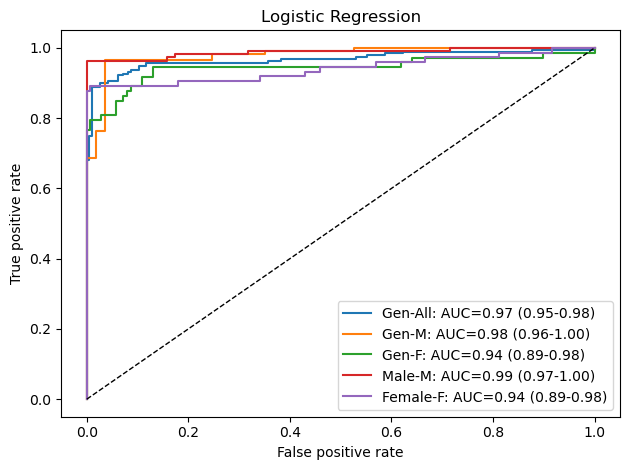

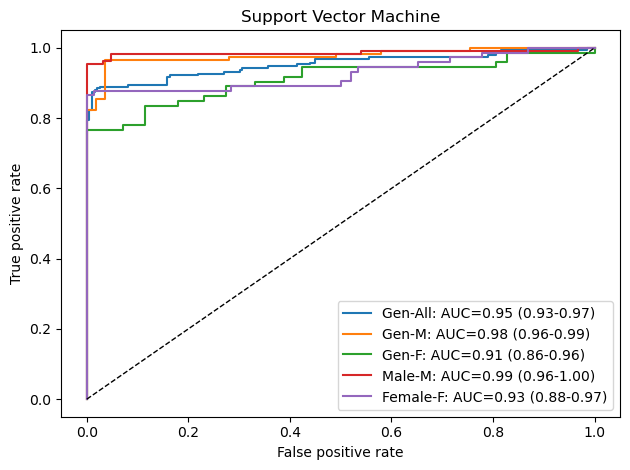

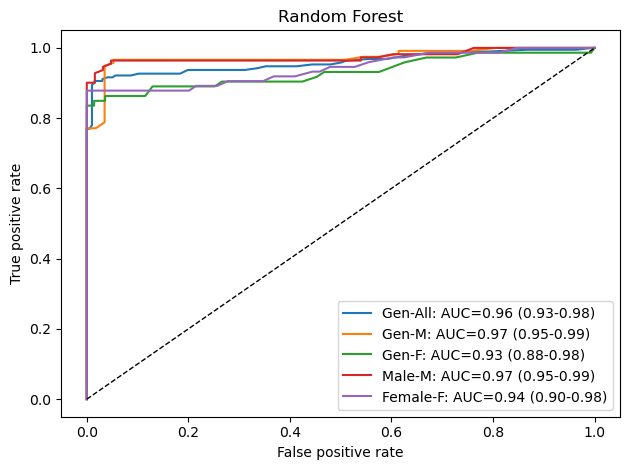

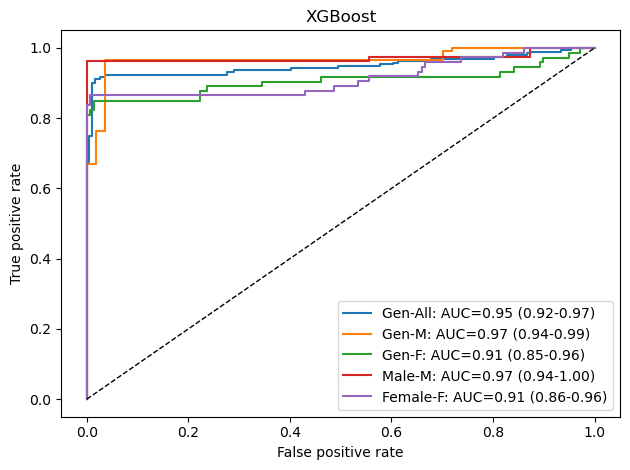

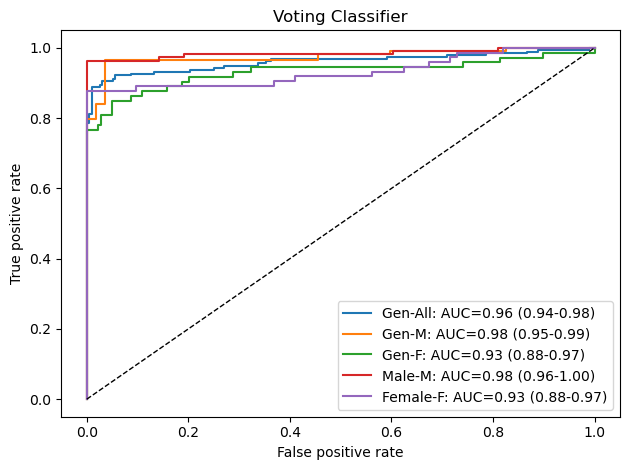

In [55]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



def parse_label(label: str):
    """
    Parse labels like 'Gen-LR-All', 'Male-VC-M', 'Female-XGB-F' into:
    (variant_tag, family_tag, test_subset)
    variant_tag in {'Gen','Male','Female'}
    family_tag in {'LR','SVM','RF','XGB','VC','MLP', ...}
    test_subset in {'All','M','F'}
    """
    m = re.match(r'^(Gen|Male|Female)-([A-Za-z0-9]+)-(All|M|F)$', label)
    if not m:
        return ("UNK", label, "UNK")
    return m.group(1), m.group(2), m.group(3)

VARIANT_DISPLAY = {
    ("Gen","All"): "Gen-All",
    ("Gen","M"):   "Gen-M",
    ("Gen","F"):   "Gen-F",
    ("Male","M"):  "Male-M",
    ("Female","F"): "Female-F",
    ("Male","F"):  "Male-F",      
    ("Female","M"): "Female-M"
}

def bootstrap_auc_ci(y_true, y_prob, n_boot=1000, seed=42, alpha=0.95):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    aucs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yt, yp = y_true[idx], y_prob[idx]
        fpr, tpr, _ = roc_curve(yt, yp)
        aucs.append(auc(fpr, tpr))
    lo = np.percentile(aucs, (1-alpha)/2*100)
    hi = np.percentile(aucs, (1+(alpha))/2*100)
    return float(np.mean(aucs)), float(lo), float(hi)



def plot_roc_variants_one_classifier(evaluation_outputs: dict, family: str,
                                     n_boot: int | None = 0, title_map: dict | None = None):
    
    # collect variants 
    series = []
    for label, df in evaluation_outputs.items():
        variant, fam, subset = parse_label(label)
        if fam != family:
            continue
        # concatenate folds
        y_true = np.concatenate(df['y_true'].to_numpy())
        y_prob = np.concatenate(df['y_proba'].to_numpy())
        series.append((variant, subset, y_true, y_prob, label))

    if not series:
        print(f"No entries found for family '{family}'.")
        return

    plt.figure()
    for variant, subset, y_true, y_prob, label in series:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        base_auc = auc(fpr, tpr)
        if n_boot and n_boot > 0:
            mean_auc, lo, hi = bootstrap_auc_ci(y_true, y_prob, n_boot=n_boot)
            leg = f"{VARIANT_DISPLAY.get((variant, subset), label)}: AUC={base_auc:.2f} ({lo:.2f}-{hi:.2f})"
        else:
            leg = f"{VARIANT_DISPLAY.get((variant, subset), label)}: AUC={base_auc:.2f}"
        plt.plot(fpr, tpr, label=leg)

    plt.plot([0,1],[0,1],'k--', linewidth=1)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    title = title_map.get(family, family) if title_map else family
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_all_classifiers(evaluation_outputs: dict, families: list[str],
                         n_boot: int | None = 0):
    pretty = {
        "LR":"Logistic Regression",
        "SVM":"Support Vector Machine",
        "RF":"Random Forest",
        "XGB":"XGBoost",
        "VC":"Voting Classifier",
        "MLP":"MLP"
    }
    for fam in families:
        plot_roc_variants_one_classifier(evaluation_outputs, fam, n_boot=n_boot, title_map=pretty)


families = ["LR", "SVM", "RF", "XGB", "VC"]  # include 
plot_all_classifiers(evaluation_outputs, families, n_boot=1000)  
